# EfficientNet

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
import numpy as np
import os
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
# Define paths to the dataset
training_data_dir = '../datasets/cinic-10-split/train'
test_data_dir = '../datasets/cinic-10-split/test'
valid_data_dir = '../datasets/cinic-10-split/valid'

# Define image size and batch size
image_size = (32, 32)
batch_size = 64

In [16]:
def load_data_from_directory(directory, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_names = [class_name for class_name in class_names if class_name != '.DS_Store']
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_file in os.listdir(class_dir):
            if img_file == '.DS_Store':
                continue  # Skip .DS_Store files
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path).convert('RGB')  # Ensure images are in RGB format
                img = img.resize(target_size)
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    # Convert labels to one-hot encoded vectors
    label_map = {label: i for i, label in enumerate(class_names)}
    labels = [label_map[label] for label in labels]
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))
    
    return np.array(images), np.array(labels)


In [17]:

# Load data from directories
pre_train_images, pre_train_labels = load_data_from_directory(training_data_dir, image_size)
pre_valid_images, pre_valid_labels = load_data_from_directory(valid_data_dir, image_size)
pre_test_images, pre_test_labels = load_data_from_directory(test_data_dir, image_size)


In [18]:
# Combine images and labels into a single array
train_data = list(zip(pre_train_images, pre_train_labels))
valid_data = list(zip(pre_valid_images, pre_valid_labels))
test_data = list(zip(pre_test_images, pre_test_labels))

# Shuffle the data
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
np.random.shuffle(test_data)

# Unzip the shuffled data
train_images, train_labels = zip(*train_data)
valid_images, valid_labels = zip(*valid_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

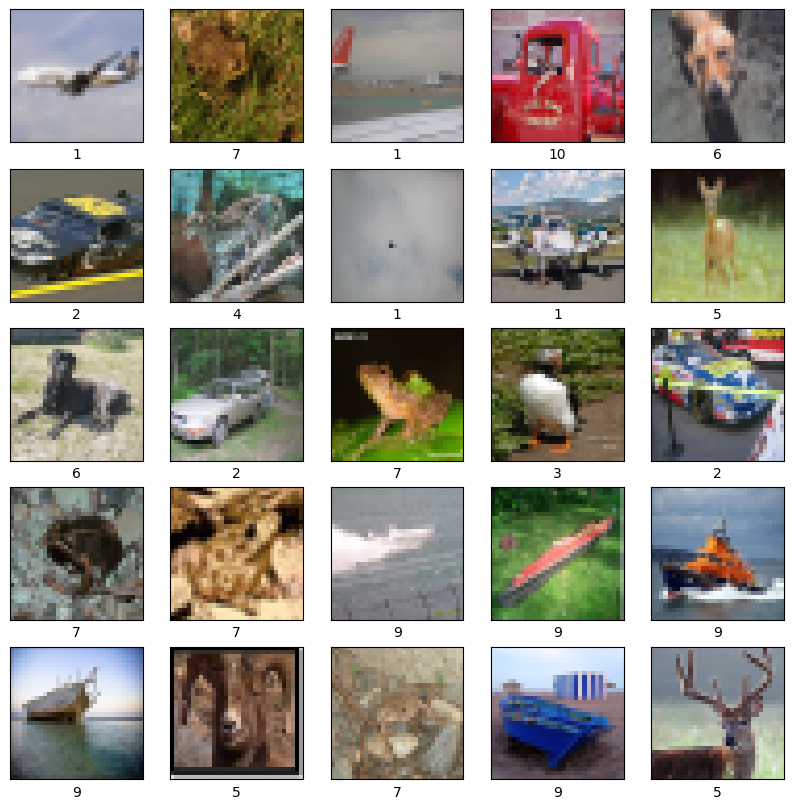

In [19]:
def one_hot_to_numerical(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1) + 1  # Add 1 to shift from 0-based indexing to 1-based indexing

# Modify show_images function to display numerical labels from 1 to 10
def show_images(images, labels):
    numerical_labels = one_hot_to_numerical(labels)
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(numerical_labels[i])  # Display numerical label
    plt.show()

# Print the first 25 images
show_images(train_images[:25], train_labels[:25])

In [20]:
# Load MobileNetV3Large without top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model layers
base_model.trainable = False


In [21]:
# Add additional layers on top of EfficientNet
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')  # Output layer with size 10 for classification
])
model.build(input_shape=(None, 32, 32, 3))
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 1, 1, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,897,382 (22.50 MB)

 Trainable params: 1,844,746 (7.04 MB)

 Non-trainable params: 4,052,636 (15.46 MB)

In [22]:
# Train the model
history = model.fit(
    train_images, 
    train_labels,
    batch_size=batch_size,
    epochs=3,
    validation_data=(valid_images,valid_labels)
)

Epoch 1/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 94s 30ms/step - accuracy: 0.3865 - loss: 1.7532 - val_accuracy: 0.4113 - val_loss: 1.6431
Epoch 2/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 86s 29ms/step - accuracy: 0.4445 - loss: 1.5454 - val_accuracy: 0.4517 - val_loss: 1.5308
Epoch 3/3
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.4597 - loss: 1.4976 - val_accuracy: 0.4646 - val_loss: 1.4787


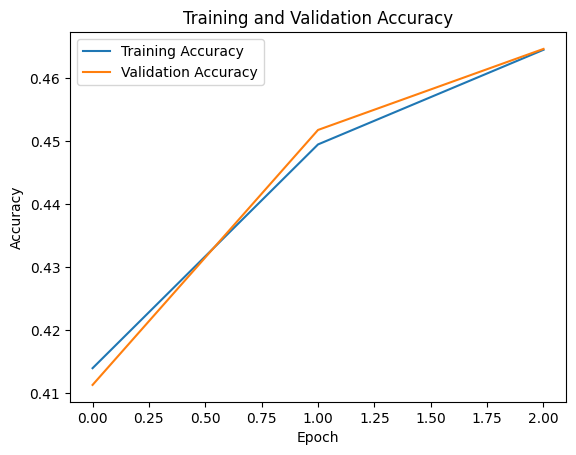

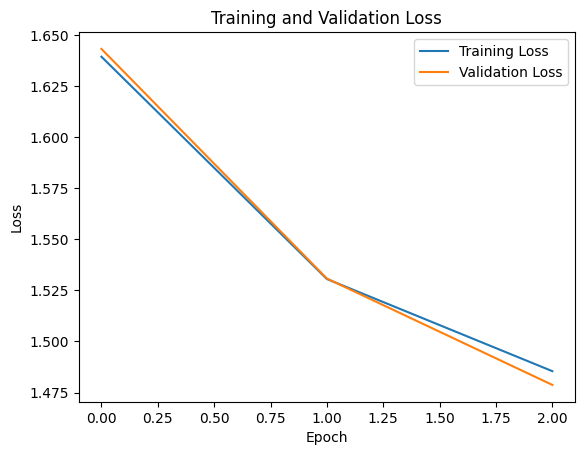

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [26]:
# Predict probabilities for test data
predictions = model.predict(test_images)

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step


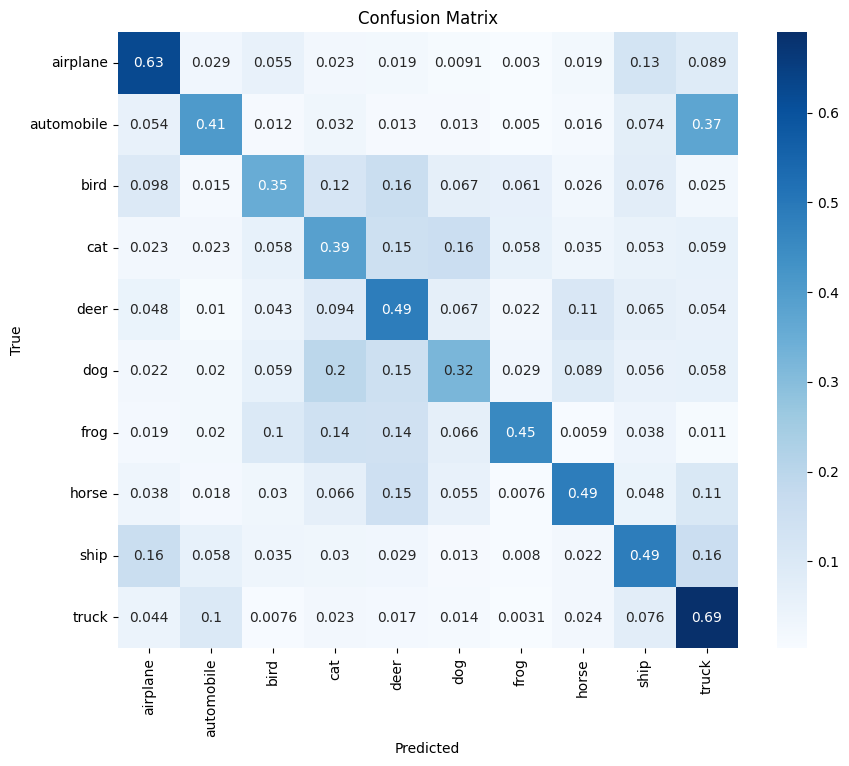

In [27]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)

# Get class labels
class_labels = sorted(os.listdir(test_data_dir))
class_labels = [class_name for class_name in class_labels if class_name != '.DS_Store']

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
